In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [15]:
from springstone.data import get_data, get_missing_dates, create_train_test, create_df_for_prophet
from springstone.utils import bollinger_bands, moving_average, prophet_preprocessing, prophet_non_business_days
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_forecast_component_plotly
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import joblib
from termcolor import colored

In [3]:
hist = get_data('AAPL')

[*********************100%***********************]  1 of 1 completed


In [4]:
hist

,Open,High,Low,Close,Volume
Date,,,,,
2012-02-21,18.102858,18.387501,18.004286,18.387501,605595200
2012-02-22,18.324286,18.410357,18.181070,18.322857,483302400
2012-02-23,18.395714,18.493929,18.196428,18.442499,568027600
2012-02-24,18.559643,18.674999,18.522858,18.657499,415072000
2012-02-27,18.618214,18.875000,18.438572,18.777143,547582000
...,...,...,...,...,...
2022-02-14,167.369995,169.580002,166.559998,168.880005,86185500
2022-02-15,170.970001,172.949997,170.250000,172.789993,64286300
2022-02-16,171.850006,173.339996,170.050003,172.550003,61177400


In [5]:
df_prophet = prophet_preprocessing(hist, 'Close')

In [6]:
non_business_days_df = prophet_non_business_days(hist)

In [7]:
df_train, df_test = create_train_test(df_prophet)

In [8]:
df_train

,ds,y
0,2012-02-21,18.387501
1,2012-02-22,18.322857
2,2012-02-23,18.442499
3,2012-02-24,18.657499
4,2012-02-25,18.657499
...,...,...
2916,2020-02-15,81.237503
2917,2020-02-16,81.237503
2918,2020-02-17,81.237503
2919,2020-02-18,79.750000


In [9]:
df_test

,ds,y
2921,2020-02-20,80.074997
2922,2020-02-21,78.262497
2923,2020-02-22,78.262497
2924,2020-02-23,78.262497
2925,2020-02-24,74.544998
...,...,...
3646,2022-02-14,168.880005
3647,2022-02-15,172.789993
3648,2022-02-16,172.550003
3649,2022-02-17,168.880005


In [10]:
m_prophet = Prophet(holidays=non_business_days_df)
m_prophet.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -80.3622


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7267.21     0.0517129       1160.68       1.166      0.1166      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7303.37     0.0106924       456.687       2.431     0.02431      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7311.95     0.0102775       774.401           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7319.48    0.00887635       625.283      0.5338           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7322.74   0.000563668       90.4905           1           1      602   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     538     

In [16]:
joblib.dump(m_prophet, 'prophet_model.joblib')
print(colored("model.joblib saved locally", "green"))

model.joblib saved locally


In [17]:
model = joblib.load('model_prophet_AAPL.joblib')

In [18]:
n_days_prediction=90
future = model.make_future_dataframe(periods=n_days_prediction)
future

,ds
0,2012-02-21
1,2012-02-22
2,2012-02-23
3,2012-02-24
4,2012-02-25
...,...
3006,2020-05-15
3007,2020-05-16
3008,2020-05-17
3009,2020-05-18


In [19]:
forecast = model.predict(future)

In [20]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'non business day']]

,ds,yhat,yhat_lower,yhat_upper,non business day
0,2012-02-21,22.166714,17.377980,26.771880,0.00000
1,2012-02-22,22.120518,17.137058,27.221208,0.00000
2,2012-02-23,21.952642,17.161865,27.060631,0.00000
3,2012-02-24,21.787783,16.805330,26.667018,0.00000
4,2012-02-25,21.663230,16.922039,26.399852,0.10711
...,...,...,...,...,...
3006,2020-05-15,66.814896,61.571892,71.872182,0.00000
3007,2020-05-16,66.821338,62.198724,71.622977,0.10711
3008,2020-05-17,66.827534,61.805551,71.914645,0.10711
3009,2020-05-18,66.898824,61.801740,72.073378,0.00000


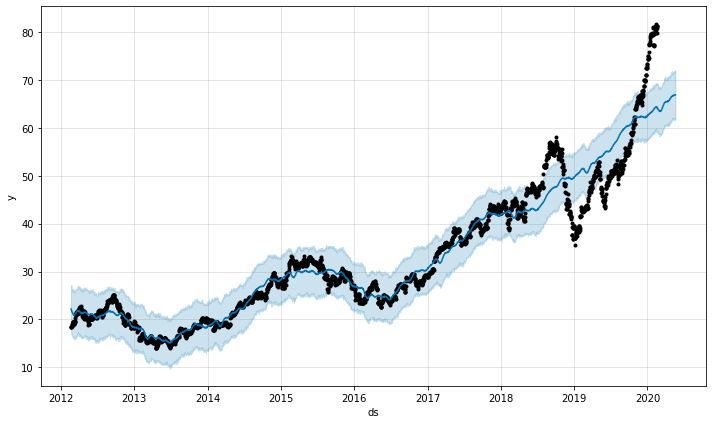

In [21]:
m_prophet.plot(forecast);

In [ ]:
m_prophet.plot_components(forecast);

In [ ]:
#plot_forecast_component_plotly(m_prophet, forecast, 'non business day')

In [ ]:
forecast = forecast[- n_days_prediction:][['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'non business day']]

In [ ]:
forecast

In [ ]:
df_test[:n_days_prediction]

In [ ]:
mae_prophet = mean_absolute_error(df_test[:n_days_prediction]['y'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(df_test[:n_days_prediction]['y'], forecast['yhat'])
print(f'MAE: {mae_prophet}')
print(f'MAPE: {mape_prophet}')